In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.7 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uni

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 7. Convolutional Neural Networks

### 7.1. From Fully Connected Layers to Convolutions

- we do not assume any structure a priori concerning how the features interact.

1. In the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image. This principle is called translation invariance (or translation equivariance).

2. The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. This is the locality principle. Eventually, these local representations can be aggregated to make predictions at the whole image level.

3. As we proceed, deeper layers should be able to capture longer-range features of the image, in a way similar to higher level vision in nature.

$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$

### 7.2. convolutions for Images

In [ ]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
# X : input, K : Kernel, corr2d : Output
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
# transpose : X.t()
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 0.841
epoch 4, loss 0.156
epoch 6, loss 0.032
epoch 8, loss 0.008
epoch 10, loss 0.002


- 결과를 관찰하면 10번의 반복 이후 오차가 확연히 감소

In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9911, -0.9997]])

### 7.3. Padding and Stride

- one tricky issue when applying convolutional layers is that we tend to lose pixels on the perimeter of our image.
- One straightforward solution to this problem is to add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image.
- producing an output with the same height and width as the input

In [ ]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

- Sometimes, we move our window more than one element at a time, skipping the intermediate locations.

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 7.4. Multiple Input and Multiple Output Channels

- When the input data contains multiple channels, we need to construct a convolution kernel with the same number of input channels as the input data
- Ex. (input : 2 * 3 * 3) * (kernel : 2 * 2 * 2) = (output : 2 * 2) dimension이 줄어든다.

In [ ]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [ ]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape
# convolution kernel with three output

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)
# Now the output contains three channels

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

- Memo
 - input 과 kernel 의 크기를 받고 output의 크기를 계산할 수 있어야 한다.
 - 3차원 텐서를 합성곱한 것과 그것을 2차원 행렬로 변환하여 합성곱한 것은 결과가 같다.
 - 2차원 행렬로 변환한 뒤 연산하는 것이 더 효율적이다.
 - pytorch의 matmul의 병렬연산을 통해 빠른 연산이 가능하기 때문이다.

### 7.5. Pooling

- the pooling layer contains no parameters (there is no kernel)
- pooling operators are deterministic, typically calculating either the maximum or the average value of the elements in the pooling window.
- 커널이 살짝 이동하더라도 경향성이 유지된다.

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d (X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

- As with convolutional layers, pooling layers change the output shape. And as before, we can adjust the operation to achieve a desired output shape by padding the input and adjusting the stride.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

- 위에서 채널이 여러 개인 경우에는 따로 설정을 해주지 않고 연산하면 모든 채널의 텐서 값을 더하는 방식으로 연산했는데, 여기서는 그런 처리 없이도 채널의 수가 유지된다

### 7.6. Convolutional Neural Networks (LeNet)

- replacing fully connected layers with convolutional layers, we will enjoy more parsimonious models that require far fewer parameters.
- At a high level, LeNet (LeNet-5) consists of two parts:
 - (i) a convolutional encoder consisting of two convolutional layers
 - (ii) a dense block consisting of three fully connected layers

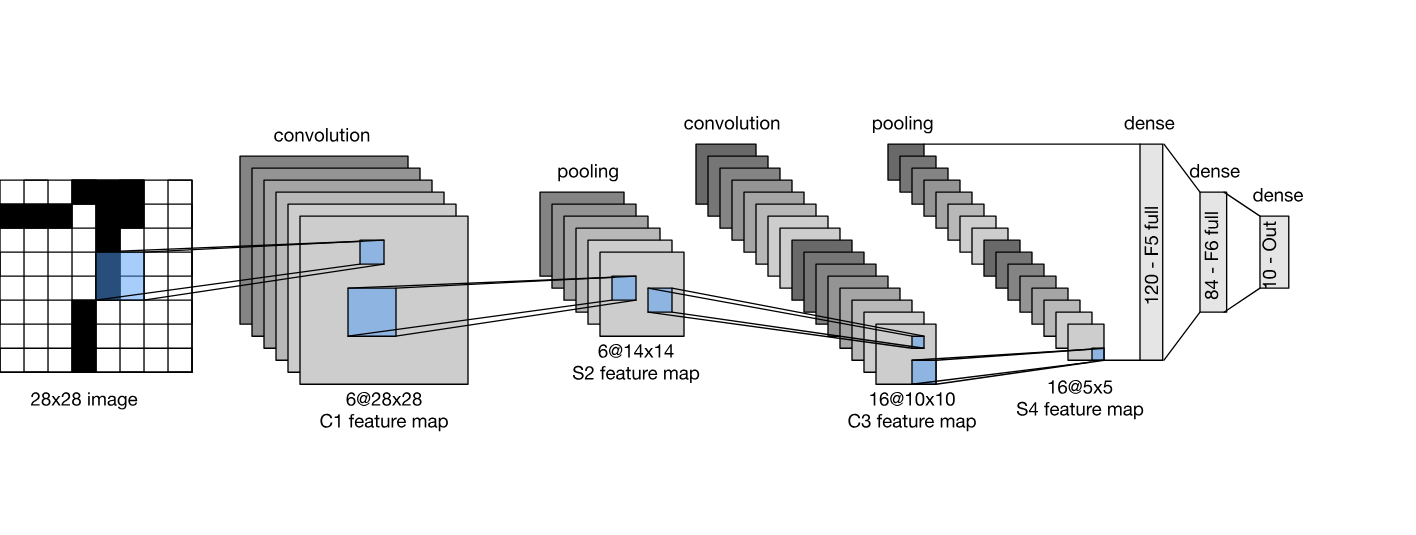

- The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Note that while ReLUs and max-pooling work better, they had not yet been discovered. Each convolutional layer uses a kernel and a sigmoid activation function. These layers map spatially arranged inputs to a number of two-dimensional feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while the second has 16. Each pooling operation (stride 2) reduces dimensionality by a factor of via spatial downsampling. The convolutional block emits an output with shape given by (batch size, number of channel, height, width).

- In order to pass output from the convolutional block to the dense block, we must flatten each example in the minibatch. In other words, we take this four-dimensional input and transform it into the two-dimensional input expected by fully connected layers: as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch and the second to give the flat vector representation of each example. LeNet’s dense block has three fully connected layers, with 120, 84, and 10 outputs, respectively. Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


- 활성화 함수는 입력값과 가중치를 통해 계산된 결과를 어떻게 변환할지 결정한다.

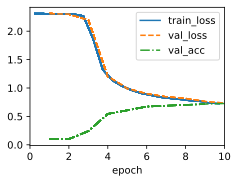

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### Discussion & Exercise

1. 3차원 텐서들이 주어지고, kernel이 1X1일 때만 2차원 행렬로 변환하여 효율적 계산이 가능한 것일까? 만약 불가능하다면 왜 불가능할까?
- 1X1 커널은 오직 채널 간의 결합만을 수행하므로, 2차원 행렬로 변환하여 효율적으로 계산할 수 있다.
- 그 이상 크기의 커널은 공간적 정보 역시도 유지해야하기 때문에, 2차원 행렬로 변환할 수 없다.
- 3차원 텐서들을 조건으로 제시한 이유는 이미지 파일은 3차원 텐서이기 때문이다.

2. torch.cat과 torch.stack의 차이는 무엇일까?
- torch.cat은 지정된 차원에서 이어붙이는 (concatenate) 방식으로 결합한다.
- torch.stack은 결합할 때마다 채널이 추가된다.

# 8. Modern Convolutional Neural Networks

### 8.2. Networks Using Blocks (VGG)

- Researchers moving from thinking in terms of individual neurons to whole layers, and now to blocks, repeating patterns of layers.
- VGG block : 여러 합성곱 층을 하나의 블럭으로 묶은 것
- VGG network : VGG block 여러 개를 쌓은 것

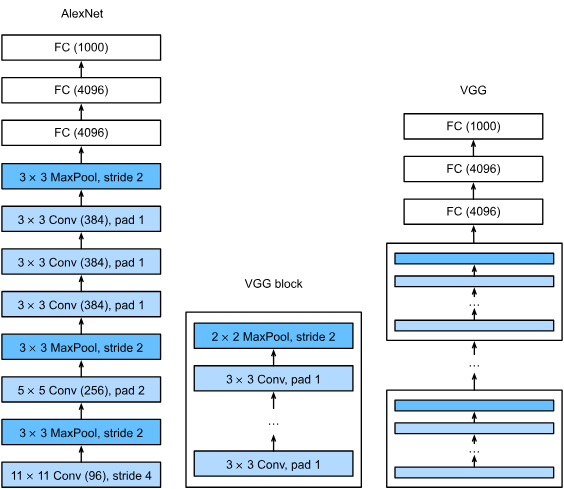

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


- The original VGG network had five convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each.
- (a, b)는 하나의 블럭. a는 한 블럭 내의 레이어의 개수. b는 출력의 개수

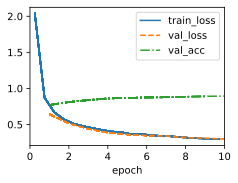

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### 8.6. Residual Networks (ResNet) and ResNeXt

- the residual block of ResNet, where the solid line carrying the layer input to the addition operator is called a residual connection
- With residual blocks, inputs can forward propagate faster through the residual connections across layers. In fact, the residual block can be thought of as a special case of the multi-branch Inception block
- ResNet has VGG’s full convolutional layer design. The residual block has two convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional convolutional layer to transform the input into the desired shape for the addition operation.

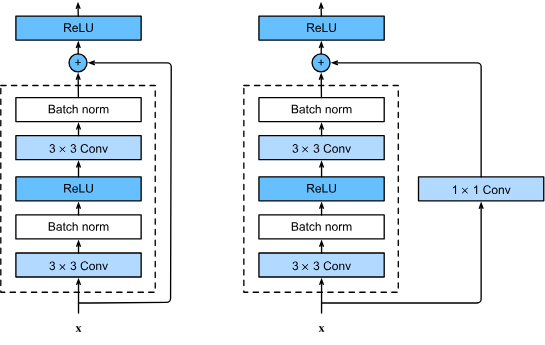

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


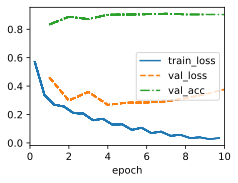

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

- ResNet에서도 합성곱 연산의 수는 CNN과 동일하지만, 학습을 할 때, 모든 단계를 학습하는 것이 아닌, rasidual block 단위로 학습을 해서 불필요한 연산의 수를 줄일 수 있다.

### Discussion & Exercise

- What are the major differences between the Inception block in Fig. 8.4.1 and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?
 - inception 블록은 여러 필터 크기와 풀링 연산을 동시에 수행한 후 결과를 연결한다. 따라서 다양한 크기로 특징을 학습할 수 있다.
 - Residual 블록은 입력과 출력을 더해주는 방식으로 작동한다. 입력데이터를 합성곱한 후 바로 출력하지 않고, 입력값을 출력값에 더해주는 구조이다.
 - 입력값을 저장한 상태로 다음 과정을 처리함으로써 gradient가 더 잘 전달되고, 더 깊은 인공신경망을 학습할 수 있다.


*

*

*

*

*

*

*

*